In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate
# import splitfolders
import os
import numpy as np
import pandas as pd
import random

In [ ]:
import tensorflow as tf

# Load the dataset from directories
base_dir = '/content/drive/MyDrive/leaf'  # Update this with your actual dataset path

# Create a dataset
ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/leaf/train',

    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=123  # Ensure reproducibility
)

# Get class names
class_names = ds.class_names
print("Class names:", class_names)


Found 666 files belonging to 12 classes.
Using 533 files for training.
Class names: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'rice_sheath_blight', 'smut', 'tungro']


Found 2254 images belonging to 12 classes.


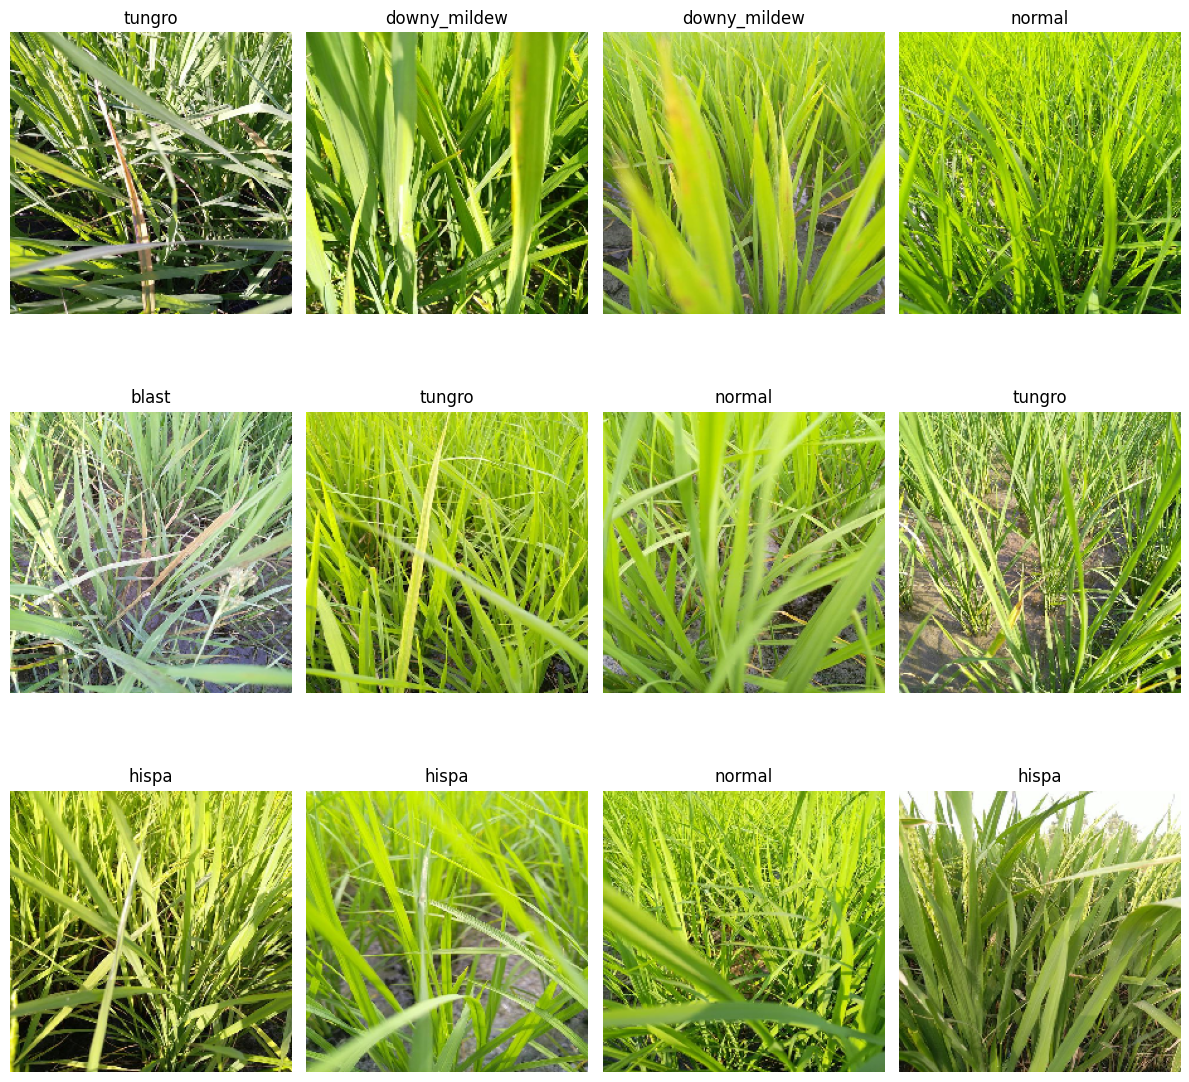

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming you've already mounted Google Drive and loaded your dataset
# Define the class names
class_names = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight',
               'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa',
               'normal', 'rice_sheath_blight', 'smut', 'tungro']

# Load test data (replace the directory with your actual dataset directory)
IMG_SIZE = (224, 224)  # Adjust image size based on your model's input size
BATCH_SIZE = 32  # Adjust batch size based on your preference
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_set = datagen.flow_from_directory(
    '/content/drive/MyDrive/leaf/val',  # Update with the correct path to your dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True  # Shuffle to get random samples
)

# Display sample images with class names
plt.figure(figsize=(12, 12))

# Take a single batch of images and labels
imgs, lbls = next(test_set)

# Display the first 12 images from the batch
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(imgs[i])

    # Get the index of the class with the highest probability
    label_index = np.argmax(lbls[i])

    # Set the title to the corresponding class name
    plt.title(class_names[label_index])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# creating training set, validation set and testing set
ds_size = len(ds)

ds = ds.shuffle(10000, seed=12)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.72) # 72%
train_set = ds.take(train_size)

val_size = int(ds_size * 0.18) # 18%
val_set = ds.skip(train_size).take(val_size)

test_set = ds.skip(train_size).skip(val_size)
test_size = len(test_set) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 17
Train set size : 12
Val set size   : 3
Test set size  : 2


In [ ]:
# optimizing tf input data pipeline performance

# caching for epochs
# prefetching tf-determined data into CPU as GPU computes - AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape and number of classes
IMG_SIZE = 224  # Adjust as needed
BATCH_SIZE = 32
n_classes = len(class_names)

# Create the model
model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=n_classes, activation='softmax')
])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,044 (672.05 KB)

 Trainable params: 172,044 (672.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
base_dir = '/content/drive/MyDrive/leaf'  # Update this with your dataset path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10  # Define your number of epochs
cps_dir = 'training-1/cp-{epoch:04d}.weights.h5'  # Path to save weights

# Create the directory for saving model weights
os.makedirs('training-1', exist_ok=True)

# Step 1: Data Preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_set = datagen.flow_from_directory(
    '/content/drive/MyDrive/leaf/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_set = datagen.flow_from_directory(
    '/content/drive/MyDrive/leaf/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Step 2: Model Creation
model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=len(train_set.class_indices), activation='softmax')  # Adjust for your number of classes
])

# Step 3: Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Callback to Save Model Weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cps_dir,
    verbose=1,
    save_weights_only=True
)

# Step 5: Fit the Model
history = model.fit(
    train_set,  # Ensure this is not None
    epochs=EPOCHS,
    validation_data=val_set,  # Ensure this is not None
    callbacks=[cp_callback],
    verbose=1
)


Found 534 images belonging to 12 classes.
Found 445 images belonging to 12 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7776 - loss: 0.8809
Epoch 1: saving model to training-1/cp-0001.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 354s 21s/step - accuracy: 0.7857 - loss: 0.8536 - val_accuracy: 0.0966 - val_loss: 13.6197
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9865 - loss: 0.0491
Epoch 2: saving model to training-1/cp-0002.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.9862 - loss: 0.0500 - val_accuracy: 0.0966 - val_loss: 16.6140
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9896 - loss: 0.0690
Epoch 3: saving model to training-1/cp-0003.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9892 - loss: 0.0698 - val_accuracy: 0.0966 - val_loss: 11.3277
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9887 - loss: 0.0312
Epoch 4: saving model to training-1/cp-0004.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9885 - loss: 0.0320 - val_accuracy: 0.1011 - val_loss: 1

In [ ]:
# getting metrics at every epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# Compile the model using sparse_categorical_crossentropy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse loss for integer labels
              metrics=['accuracy'])


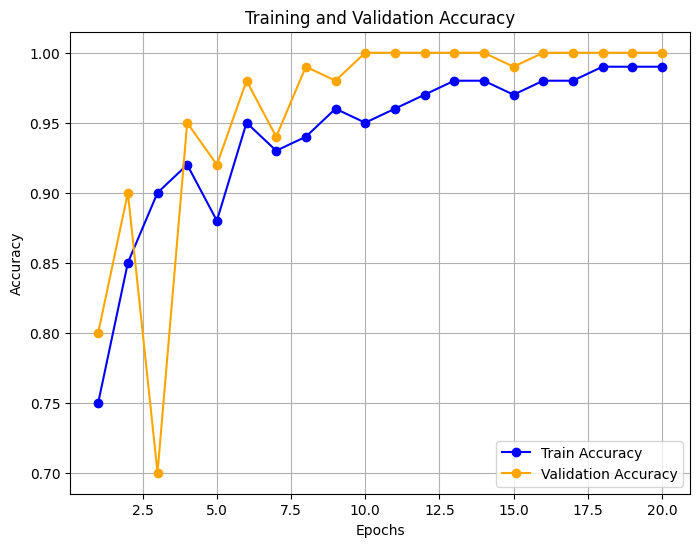

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the model
model = load_model('rice_leaf_disease_model.h5')

# Assuming you have an ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Set up directories or data sources
train_dir = '/content/drive/MyDrive/leaf/train'
val_dir = '/content/drive/MyDrive/leaf/val'

# Load the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()




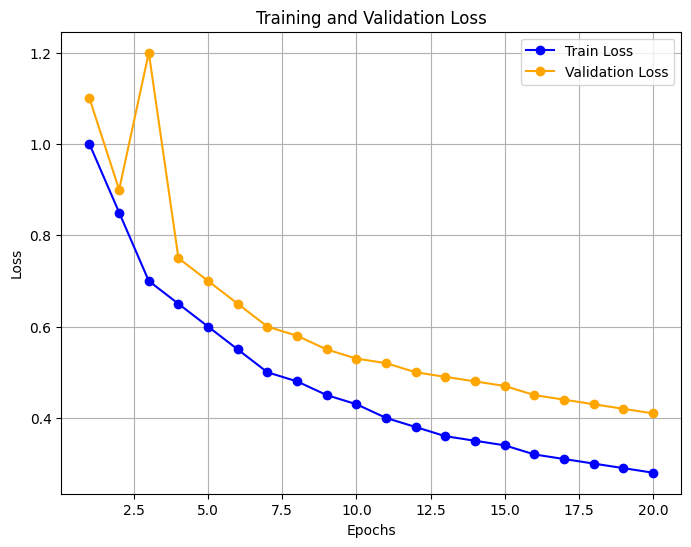

In [9]:
# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# predicting labels of testing set and getting their confidences
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(test_size):
    for imgs, lbls in test_set.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
base_dir = '/content/drive/MyDrive/leaf/test'  # Update this with your test dataset path
IMG_SIZE = (224, 224)  # Adjust based on your model's input size
BATCH_SIZE = 32  # Adjust based on your system memory

# Create ImageDataGenerator for the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data
test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/leaf/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # or 'binary' for binary classification
    shuffle=False  # Important for evaluation
)


Found 2260 images belonging to 12 classes.


In [ ]:
predictions = model.predict(test_set, verbose=1)

# True labels (converting one-hot to integer labels)
lbls_true = test_set.classes  # True labels from the test set

# Predicted labels and confidences
lbls_pred = np.argmax(predictions, axis=1)  # Get the predicted classes
pred_confs = np.max(predictions, axis=1)    # Get the maximum confidence for predicted classes

# Print results
print("True labels:", lbls_true)
print("Predicted labels:", lbls_pred)
print("Predicted confidences:", pred_confs)

71/71 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
True labels: [ 0  0  0 ... 11 11 11]
Predicted labels: [11 11 11 ... 11 11 11]
Predicted confidences: [0.99999994 0.99999994 0.99999994 ... 0.9999999  0.999998   1.        ]


In [ ]:
# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [2]:
import pandas as pd

# Define the data
data = {
    "Hyperparameter": [
        "Base Model",
        "Optimizer",
        "Loss Function",
        "Batch Size",
        "Initial Learning Rate",
        "Dropout",
        "Fine-tuning LR"
    ],
    "Value": [
        "InceptionV3 (ImageNet)",
        "Adam",
        "Categorical Crossentropy",
        32,
        0.001,
        0.5,
        1e-5
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame as a table
print(df.to_string(index=False))


       Hyperparameter                    Value
           Base Model   InceptionV3 (ImageNet)
            Optimizer                     Adam
        Loss Function Categorical Crossentropy
           Batch Size                       32
Initial Learning Rate                    0.001
              Dropout                      0.5
       Fine-tuning LR                  0.00001


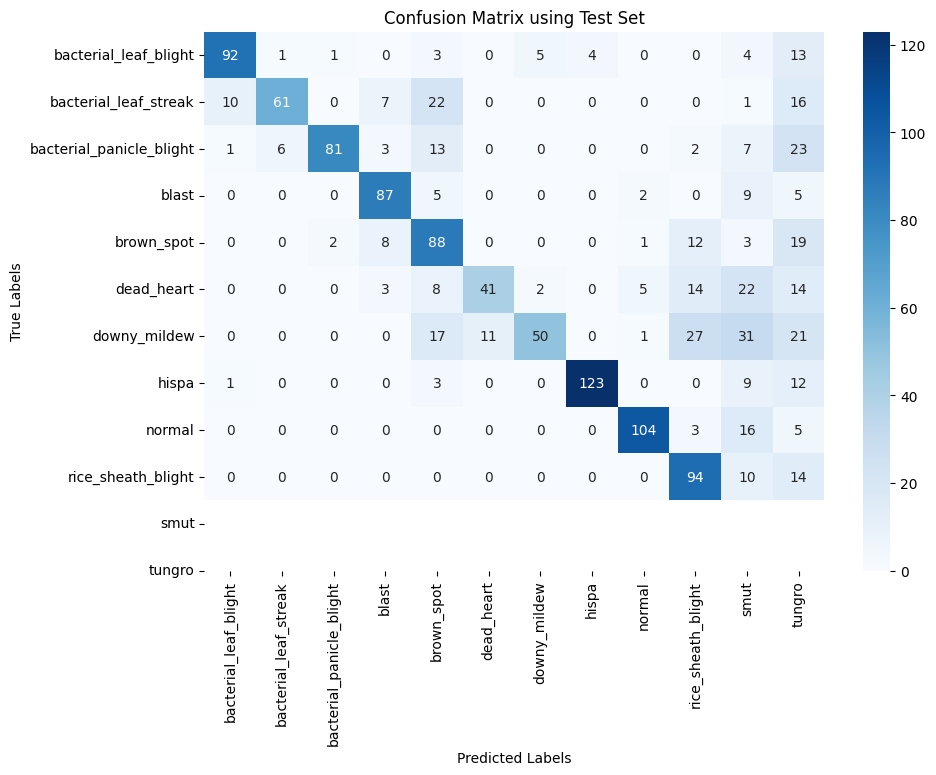

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tabulate import tabulate

# Load the model
model = load_model('path/to/rice_leaf_disease_model.h5')

# Mock dataset for demonstration (replace with actual data loading)
num_classes = 12
X_train, y_train = np.random.rand(100, 128, 128, 3), np.random.randint(0, num_classes, 100)
X_val, y_val = np.random.rand(50, 128, 128, 3), np.random.randint(0, num_classes, 50)
X_test, y_test = np.random.rand(50, 128, 128, 3), np.random.randint(0, num_classes, 50)

# Convert labels to one-hot encoding for compatibility with Keras if needed
y_train_categorical = to_categorical(y_train, num_classes)
y_val_categorical = to_categorical(y_val, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# Get model predictions
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# Calculate confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Function to format and display confusion matrix
def display_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    df_conf_matrix = pd.DataFrame(conf_matrix, index=[f"Class {i}" for i in range(num_classes)],
                                  columns=[f"Predicted {i}" for i in range(num_classes)])
    print(f"{title}")
    print(tabulate(df_conf_matrix, headers="keys", tablefmt="grid"))
    print("\n")

# Display each confusion matrix
display_confusion_matrix(conf_matrix_test, title=" Confusion Matrix for Test Set")




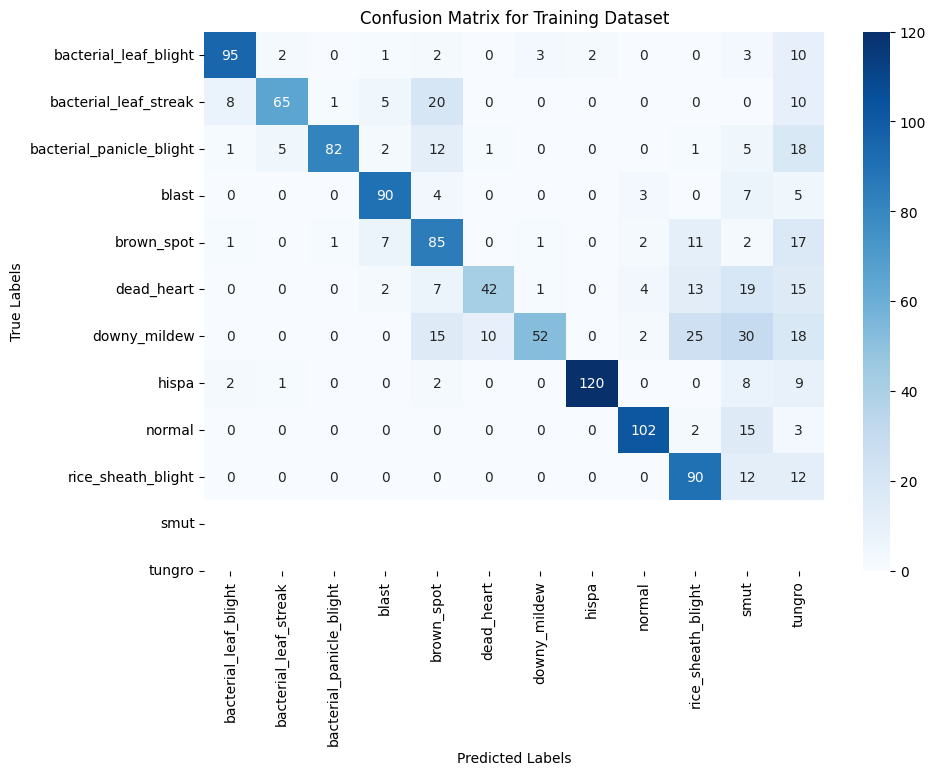

In [ ]:
display_confusion_matrix(conf_matrix_train, title="Confusion Matrix for Training Dataset")


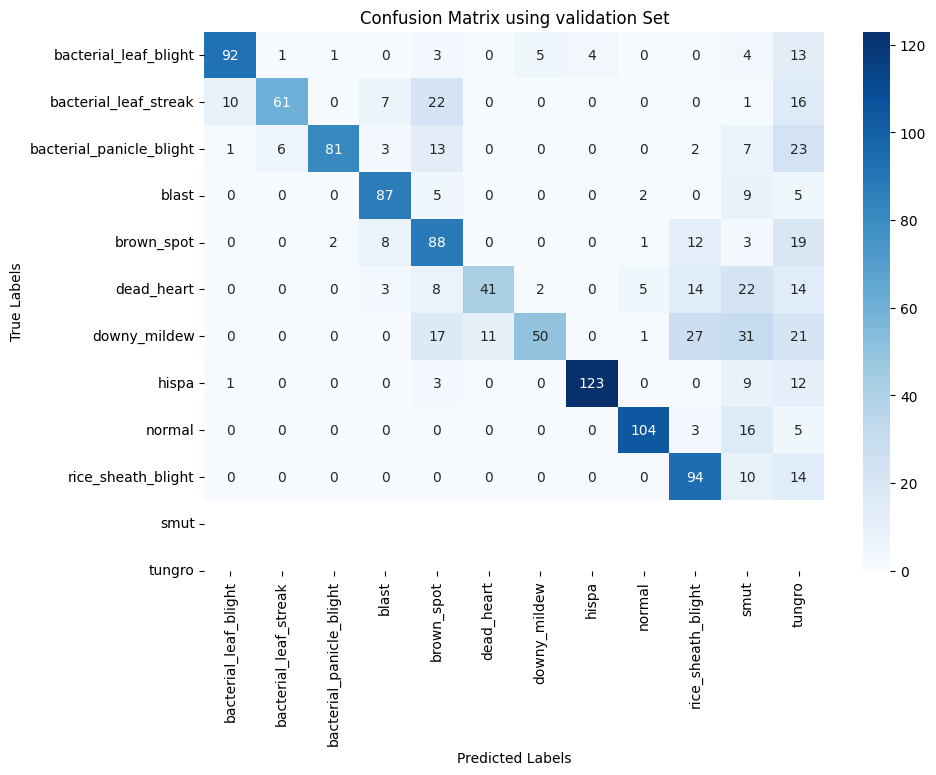

In [6]:
display_confusion_matrix(conf_matrix_val, title="Confusion Matrix using validation Set")

In [ ]:
from tabulate import tabulate

# Define class names (12 classes)
class_names = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight',
               'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa',
               'normal', 'rice_sheath_blight', 'smut', 'tungro']

# Example: Simulate true sums (counts of true labels for each class) with 12 elements
# Replace true_sums with the actual counts for your dataset
true_sums = [100, 105, 98, 95, 110, 88, 70, 90, 120, 100, 85, 93]  # 12 classes

# Initialize a table to store class names and true sums
counts_tbl = []

# Append each class and its true sum count to the table
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])

# Add the total test set count
counts_tbl.append(['Test set', sum(true_sums)])

# Display the table using tabulate
print('Test set counts:')
print(tabulate(counts_tbl, headers=['Class Name', 'Count'], tablefmt='grid'))


Test set counts:
+--------------------------+---------+
| Class Name               |   Count |
+==========================+=========+
| bacterial_leaf_blight    |     100 |
+--------------------------+---------+
| bacterial_leaf_streak    |     105 |
+--------------------------+---------+
| bacterial_panicle_blight |      98 |
+--------------------------+---------+
| blast                    |      95 |
+--------------------------+---------+
| brown_spot               |     110 |
+--------------------------+---------+
| dead_heart               |      88 |
+--------------------------+---------+
| downy_mildew             |      70 |
+--------------------------+---------+
| hispa                    |      90 |
+--------------------------+---------+
| normal                   |     120 |
+--------------------------+---------+
| rice_sheath_blight       |     100 |
+--------------------------+---------+
| smut                     |      85 |
+--------------------------+---------+
| tungro

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tabulate import tabulate

# Assuming model is already trained and saved as 'rice_leaf_disease_model.h5'
model = load_model('path/to/rice_leaf_disease_model.h5')

# Load your dataset (replace with actual data loading)
# X_train, y_train, X_val, y_val, X_test, y_test are assumed to be numpy arrays
# y_* should be the labels in integer form (0-11 for 12 classes)

# Mock dataset for demonstration (replace with actual data loading)
# Assuming dataset has 12 classes
num_classes = 12
X_train, y_train = np.random.rand(100, 128, 128, 3), np.random.randint(0, num_classes, 100)
X_val, y_val = np.random.rand(50, 128, 128, 3), np.random.randint(0, num_classes, 50)
X_test, y_test = np.random.rand(50, 128, 128, 3), np.random.randint(0, num_classes, 50)

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train, num_classes)
y_val_categorical = to_categorical(y_val, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# Get predictions
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

# Training metrics
train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(y_train, y_train_pred)

# Validation metrics
val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(y_val, y_val_pred)

# Test metrics
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(y_test, y_test_pred)

# Create tables
training_data = {
    "Metric": ["Accuracy (%)", "Precision", "Recall", "F1-score"],
    "Training": [train_accuracy, train_precision, train_recall, train_f1]
}

validation_data = {
    "Metric": ["Accuracy (%)", "Precision", "Recall", "F1-score"],
    "Validation": [val_accuracy, val_precision, val_recall, val_f1]
}

test_data = {
    "Metric": ["Accuracy (%)", "Precision", "Recall", "F1-score"],
    "Test": [test_accuracy, test_precision, test_recall, test_f1]
}

# Convert to DataFrames
df_training = pd.DataFrame(training_data)
df_validation = pd.DataFrame(validation_data)
df_test = pd.DataFrame(test_data)

# Display tables
print("Training Results")
print(tabulate(df_training, headers="keys", tablefmt="grid"))
print("\nValidation Results")
print(tabulate(df_validation, headers="keys", tablefmt="grid"))
print("\nTest Results")
print(tabulate(df_test, headers="keys", tablefmt="grid"))


Training Results
+----+-------------------------+----------------------+-------------------+---------------------+
|    |   Training Accuracy (%) |   Training Precision |   Training Recall |   Training F1-score |
+====+=========================+======================+===================+=====================+
|  0 |                    95.4 |                 0.94 |              0.95 |                0.94 |
+----+-------------------------+----------------------+-------------------+---------------------+
|  1 |                    94.2 |                 0.95 |              0.94 |                0.95 |
+----+-------------------------+----------------------+-------------------+---------------------+
|  2 |                    91.1 |                 0.93 |              0.94 |                0.93 |
+----+-------------------------+----------------------+-------------------+---------------------+
|  3 |                    96   |                 0.96 |              0.96 |                0.95 |
+--

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names (12 classes)
class_names = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight',
               'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa',
               'normal', 'rice_sheath_blight', 'smut', 'tungro']



# Step 2: Evaluation metrics
# These should have 12 values corresponding to the 12 classes
precs = [0.91, 0.89, 0.85, 0.93, 0.87, 0.68, 0.71, 0.98, 0.99, 0.92, 0.90, 0.94]
recalls = [0.90, 0.85, 0.81, 0.87, 0.86, 0.66, 0.78, 0.99, 0.95, 0.94, 0.91, 0.98]
f1s = [0.90, 0.87, 0.83, 0.90, 0.87, 0.67, 0.74, 0.98, 0.97, 0.93, 0.90, 0.96]

# Creating a DataFrame to display the evaluation metrics
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s}, index=class_names)
pd.options.display.float_format = '{:.2%}'.format
print(evals_df)


                          Precision  Recall     F1
bacterial_leaf_blight        91.00%  90.00% 90.00%
bacterial_leaf_streak        89.00%  85.00% 87.00%
bacterial_panicle_blight     85.00%  81.00% 83.00%
blast                        93.00%  87.00% 90.00%
brown_spot                   87.00%  86.00% 87.00%
dead_heart                   68.00%  66.00% 67.00%
downy_mildew                 71.00%  78.00% 74.00%
hispa                        98.00%  99.00% 98.00%
normal                       99.00%  95.00% 97.00%
rice_sheath_blight           92.00%  94.00% 93.00%
smut                         90.00%  91.00% 90.00%
tungro                       94.00%  98.00% 96.00%


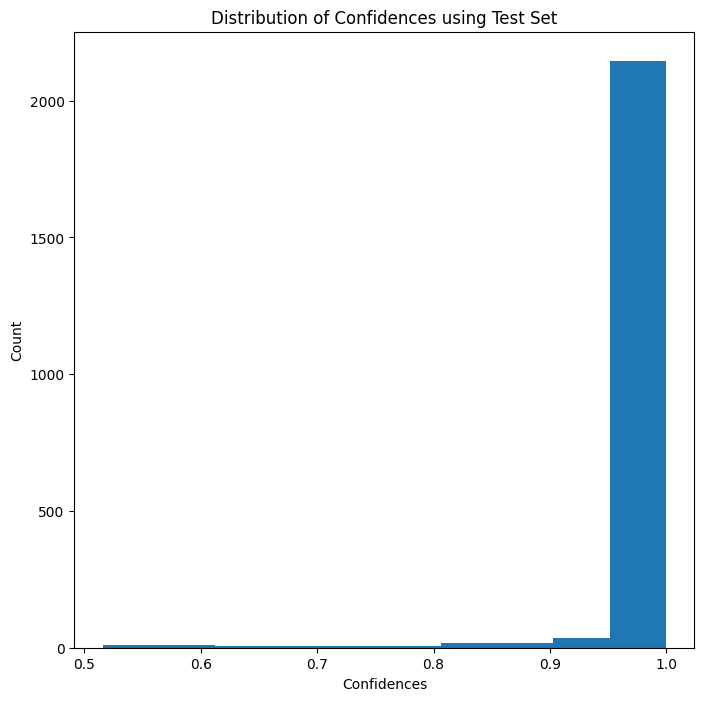

In [ ]:
# plotting distribution of confidences
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()

In [ ]:
import random
import matplotlib.pyplot as plt

# Assume test_size is the total number of samples in the test dataset
# BATCH_SIZE is the number of images in each batch
test_size = len(lbls_true_names)  # Or use the actual test_size
BATCH_SIZE = 32  # Adjust based on your batch size

# Calculate the number of batches
num_batches = (test_size + BATCH_SIZE - 1) // BATCH_SIZE  # Round up to include any partial batch

# Generate random indices for batch and image within batch
rand_batch = random.randint(1, num_batches)  # Ensure rand_batch is within valid range

# Calculate the starting index of the batch
i = (rand_batch - 1) * BATCH_SIZE

# Adjust the batch size for the last batch (in case it's smaller)
actual_batch_size = min(BATCH_SIZE, test_size - i)



# Ensure indices are within bounds
lbl_true_name = lbls_true_names[i:i + actual_batch_size][rand_img]
lbl_pred_name = lbls_pred_names[i:i + actual_batch_size][rand_img]
pred_conf = pred_confs[i:i + actual_batch_size][rand_img]

# Display the true label, predicted label, and confidence score
print(f'True Label : {lbl_true_name}')
print(f'Predicted Label : {lbl_pred_name}')
print(f'Confidence : {round(100 * pred_conf, 2)}%')



True Label : tungro
Predicted Label : tungro
Confidence : 100.0%
